In [2]:
import os, sys, re, cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import matplotlib.backends.backend_pdf
from matplotlib.patches import Rectangle

import numpy as np
from numpy import flip, arange, reshape

import seaborn as sns
import pandas as pd
import glob

import scipy
from scipy.signal import correlate2d, fftconvolve
from scipy import ndimage
from scipy.ndimage import maximum_filter
from scipy.spatial import distance_matrix, Delaunay, Voronoi, voronoi_plot_2d

import math
from PIL import Image

from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

import pointpats

from render2D import grid2D

from utils import *

# Functions

## 1D Functions

In [ ]:
def iFFT(ft):
    ft = np.fft.ifftshift(ft)
    ift = np.fft.ifft2(ft)
    ift = np.fft.fftshift(ift)
    return(ift.real)   # take only the real part since computational error leads to noise in imaginary part

def FFT(img):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ft = np.fft.ifftshift(img)
    ft = np.fft.fft2(ft)
    return(np.fft.fftshift(ft))

def FFTplot(img, size=10, plot=1, **plot_args):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ft = FFT(img)

    if plot == 1:
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(np.real(ft), cmap='PuOr', **plot_args)
    return ft

def iFFTplot(ft, xylen=10, plot=1, angle="h", **plot_args):
    ift = iFFT(ft)
    a, _ =ft.shape
    xyrange = [a//2-xylen, a//2+xylen]
    if plot == 1:
        if angle == "h":
            plt.figure()
            ax=plt.subplot(121)
            ax.set_xlim(xyrange)
            ax.set_ylim(xyrange)
            plt.imshow(abs(ft), **plot_args)
            plt.subplot(122)
            plt.imshow(ift)
        elif angle == "v":
            plt.figure()
            ax=plt.subplot(211)
            ax.set_xlim(xyrange)
            ax.set_ylim(xyrange)
            plt.imshow(abs(ft), **plot_args)
            plt.subplot(212)
            plt.imshow(ift)
    return(ift)

# also used for clustering?
def local_maximum(mx, r):
    tmp=ndimage.maximum_filter(mx, size=r)
    return(np.where(mx == tmp, mx, 0))

def mainFFT(ft, n=5, isSep=1, xylen=10, **plot_args):
    """Plot the top N FT frequencies separately and their corresponding waves, return the complex values as a list 

    """
    ft_sort=np.unravel_index(np.argsort(-abs(ft), axis=None),ft.shape)
    a, _ =ft.shape
    xyrange = [a//2-xylen, a//2+xylen]
    if isSep == 1:
        plt.figure(figsize=[5*(n+2),10])
        plt.subplot(2,2+n,1)
        plt.imshow(iFFT(ft))
        ax=plt.subplot(2,2+n,3+n)
        ax.set_xlim(xyrange)
        ax.set_ylim(xyrange)
        nft=np.zeros([64,64],dtype=complex)
        nft[ft_sort[0][1:2*n+1],ft_sort[1][1:2*n+1]]=ft[ft_sort[0][1:2*n+1],ft_sort[1][1:2*n+1]]
        plt.imshow(np.abs(nft), **plot_args)
        ax=plt.subplot(2,2+n,4+n)
        ax.set_xlim(xyrange)
        ax.set_ylim(xyrange)
        plt.imshow(local_maximum(np.abs(nft),3), cmap = 'PuOr', **plot_args)    
        for i in range(n):
            nft=np.zeros([64,64],dtype=complex)
            nft[ft_sort[0][2*i+1:2*(i+1)+1],ft_sort[1][2*i+1:2*(i+1)+1]]=ft[ft_sort[0][2*i+1:2*(i+1)+1],ft_sort[1][2*i+1:2*(i+1)+1]]
            #nft[ft_sort[0][i+1],ft_sort[1][i+1]]=ft[ft_sort[0][i+1],ft_sort[1][i+1]]
            #nft[ft_sort[0][i],ft_sort[1][i]]=ft[ft_sort[0][i],ft_sort[1][i]]
            ax=plt.subplot(2,2+n,n+i+5)
            ax.set_xlim(xyrange)
            ax.set_ylim(xyrange)
            plt.imshow(np.abs(nft), **plot_args)
            plt.subplot(2,2+n,i+2+1)
            plt.imshow(iFFT(nft), **plot_args)
    else:
        nft=np.zeros([64,64],dtype=complex)
        nft[ft_sort[0][1:n*2+1],ft_sort[1][1:n*2+1]]=ft[ft_sort[0][1:n*2+1],ft_sort[1][1:n*2+1]]
        plt.figure(figsize=[9,3])
        plt.subplot(1,3,1)
        plt.imshow(iFFT(ft), **plot_args)
        ax=plt.subplot(1,3,2)
        ax.set_xlim(xyrange)
        ax.set_ylim(xyrange)
        plt.imshow(np.abs(nft), cmap="PuOr", **plot_args)
        plt.subplot(1,3,3)
        plt.imshow(iFFT(nft), **plot_args)

    return([ft_sort[0][1:2*(n+1)+1],ft_sort[1][1:2*(n+1)+1]], ft[ft_sort[0][1:2*(n+1)+1],ft_sort[1][1:2*(n+1)+1]])


def unit_circle(n, rrange):
    A = np.arange(-n+0.5,n+0.5)**2
    dists = np.sqrt(A[:,None] + A)
    return ((dists-rrange[0]>0.5) & (rrange[1]-dists >= -0.5)).astype(int)


# The functions for testing differences among the 4 scenarios
def plot_sum_r(ft, r):
    freqs=[ np.sum(np.real(ft)*unit_circle(32,x)) for x in range(r)]
    plt.plot(freqs)

def plot_max_r(ft, r):
    freqs=[ np.max((np.real(ft)*unit_circle(32,x)).flatten()) for x in range(r)]
    plt.plot(freqs/freqs[1])


def plot_ratio_r(ft, r):
    ratios=[ np.max((np.real(ft)*unit_circle(32,x)).flatten())/(np.min((np.real(ft)*unit_circle(32,x)).flatten())+1) for x in range(r)]
    plt.plot(ratios/ratios[1])

def plot_max3_r(ft, r):
    freqs=[ np.sort((np.real(ft)*unit_circle(32,x)).flatten())[-3]/np.max((np.real(ft)*unit_circle(32,1)).flatten()) for x in range(r)]
    plt.plot(freqs/freqs[1])

# def plot_max3_r(ft, r):
#     ratios=[ np.max((np.real(ft)*unit_circle(32,x)).flatten())/(np.sort((np.real(ft)*unit_circle(32,x)).flatten())[-3]+1) for x in range(r)]
#     ratios[1]=0
#     plt.plot(ratios)

def plot_avg6_r(ft, r):
    ratios = [ np.mean(np.sort((np.real(ft)*unit_circle(32,x)).flatten())[-6:])/np.max((np.real(ft)*unit_circle(32,1)).flatten()) for x in range(r) ]
    plt.plot(ratios)
    return [np.sort((np.real(ft)*unit_circle(32,x)).flatten())[-6:] for x in range(r)]


PSF=[[] for x in range(20)]
for size in range(20):
    sigma_y = sigma_x = 0.5
    k=1
    x = np.linspace(-k, k, size)
    y = np.linspace(-k, k, size)
    x, y = np.meshgrid(x, y)
    PSF[size] = 255 * np.exp(-(x**2/(2*sigma_x**2)+ y**2/(2*sigma_y**2)))

def genPic(matrix, locs, point=9, theta=0, rand=0, randz=0):
    sx,sy = PSF[point].shape
    mx,my = matrix.shape
    locs = locs.astype(int)
    tmp_matrix=np.pad(matrix, (sx, sy), mode="constant", constant_values=0)
    for px, py in locs:
        if rand!=0:
            px+=np.random.randint(2*rand)-rand
            py+=np.random.randint(2*rand)-rand
        tpoint = point+np.random.randint(randz)
        px-=tpoint//2
        py-=tpoint//2
        if px < 0 or px+tpoint > mx or py < 0 or py+tpoint > my:
            continue
        tmp_matrix[px:px+tpoint, py:py+tpoint] += PSF[tpoint]
    if theta != 0:
        rotated = ndimage.rotate(tmp_matrix, theta)
        tmp,_ = rotated.shape
        return(rotated[tmp//2-mx//2:tmp//2+mx//2,tmp//2-my//2:tmp//2+my//2])
    else:
        return(tmp_matrix[sx:-sx,sy:-sy])

def sim1D(size=128, spacex=8, spacey=11, shift=0):
    points=[]
    for py in range(1, size, spacey):
        for px in range(1+py//int(spacey)*shift, size, spacex):
            points.append([px,py])
    return(np.array(points))

def simRand3(size, n, d, d_rand=3):
    vxs=[]
    vx = np.random.rand(2)*size
    vxs.append(vx)
    for i in range(n-1):
        theta = np.random.rand()*2*np.pi
        di = d+np.random.rand()*d_rand-d_rand/2
        new_vx = [vx[0]+di*np.cos(theta), vx[1]+di*np.sin(theta)]
        while new_vx[0] < 0 or new_vx[0] > size or new_vx[1] < 0 or new_vx[1] > size:
            theta = np.random.rand()*2*np.pi
            new_vx = [vx[0]+di*np.cos(theta), vx[1]+di*np.sin(theta)]
        vxs.append(new_vx)
        vx = new_vx
    return(np.array(vxs))

def sim2D(size=128, space=6):
    nx=ny=int(size/space)
    return np.array([[int((x*2-y%2)*space)+10, int(y*np.sqrt(3)*space)] for x in range(nx) for y in range(ny)])

def sim2DC(size=128, space=6):
    N_points=sim2D(size, space)
    N_dist = [[np.linalg.norm(i-j) for i in N_points] for j in N_points ]
    thre = space*2+1
    C_points = []
    n_vx = len(N_points)
    for i in range(n_vx):
        for j in range(i+1, n_vx):
            if N_dist[i][j] <= thre:
                C_points.append([(N_points[i][0]+N_points[j][0])//2, (N_points[i][1]+N_points[j][1])//2])
    return(np.array(C_points))

def simRand(size=128,n=50):
    return(np.random.randint(size,size=(n,2)))

def simRand2(size=128, n=50, d=187):
    sim = np.random.randint(size,size=(int(n/2),2))
    sim2 = []
    for x in sim:
        theta = np.random.rand()*2*np.pi
        new_vx = [x[0]+d*np.cos(theta), x[1]+d*np.sin(theta)]
        while new_vx[0] < 0 or new_vx[0] > size or new_vx[1] < 0 or new_vx[1] > size:
            theta = np.random.rand()*2*np.pi
            new_vx = [x[0]+d*np.cos(theta), x[1]+d*np.sin(theta)]
        sim2.append(new_vx)
    return(np.append(sim, np.array(sim2), axis=0))

def simRandD(box=100, d=5, n=20):
    points = []
    i = 0
    c = 0
    while i<n and c<20:
        t_vx = np.random.rand(2)*box
        t_flag = 1
        for vx in points:
            if np.linalg.norm(t_vx-vx)<d:
                t_flag = 0
                c+=1
                break
        if t_flag == 1:
            points.append(t_vx)
            i+=1
            c=0
    return np.array(points)
# simulate continuous graph and test

def sim_d(d, c_point, len, dist, width, w_d=3):
    points=[]
    for x in range(1, len+1):
        point=[[c_point[0]+width*np.sin(d)*y, c_point[1]-width*np.cos(d)*y] for y in range(-w_d, w_d)]
        #print(x)
        #print(point)
        points.extend(point)
        c_point=[c_point[0]+dist*np.cos(d), c_point[1]+dist*np.sin(d)]
    return(c_point, points)


def sim_1dgraph(c_point=[50,50], d=np.pi/4, dist=11, width=8, **genPic_args):
    points=[]
    # for i in range(3):
    #     tmp_d=2*np.pi*np.random.rand()
    for tmp_d in [90-np.random.randint(18)*10 for x in range(10)]:
        tmp_d = tmp_d/180*np.pi
        for j in np.linspace(0,tmp_d, 10):
            c_d = d+j
            length = np.random.randint(5)
            c_point, c_points=sim_d(d=c_d, c_point=c_point, len=length, dist=dist, width=width)
            #print(c_d, c_point, len)
            points.extend(c_points)
        d = d+tmp_d
        if(np.max(np.abs(c_point)))> 1080 or c_point[0]<0 or c_point[1]<0:
            break
        c_point, c_points=sim_d(d=c_d, c_point=c_point, len=np.random.randint(5), dist=dist, width=width)
        points.extend(c_points)
        if(np.max(np.abs(c_point)))> 1080 or c_point[0]<0 or c_point[1]<0:
            break

    points=np.array(points).astype(int)
    simD = genPic(np.zeros([1280,1280]), points, **genPic_args)
    plt.figure(figsize=[10,10])
    plt.imshow(simD)
    return simD

def maximum(A, B):
    BisBigger = A-B
    BisBigger = np.where(BisBigger < 0, 1, 0)
    return A - A*(BisBigger) + B*(BisBigger)

def maskMat(img, label, kernel_size=64, steps=16):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    xn, yn=img.shape
    x_l = [ x for x in range(0,xn-kernel_size+1, steps)]
    y_l = [ y for y in range(0,yn-kernel_size+1, steps)]
    matrix = np.zeros([xn, yn])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            if(label[i,j]):
                xi = x_l[i]
                yj = y_l[j]
                matrix[xi:xi+kernel_size,yj:yj+kernel_size] = img[xi:xi+kernel_size,yj:yj+kernel_size]
    return matrix

def maxMat(img, c, kernel_size=64, steps=16):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    xn, yn=img.shape
    x_l = [ x for x in range(0,xn-kernel_size+1, steps)]
    y_l = [ y for y in range(0,yn-kernel_size+1, steps)]
    matrix = np.zeros([xn, yn])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            matrix[xi:xi+kernel_size,yj:yj+kernel_size] = maximum(matrix[xi:xi+kernel_size,yj:yj+kernel_size], c[i,j])
    return matrix

def sumMat(img, c, kernel_size=64, steps=16, method="default"):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    xn, yn=img.shape
    x_l = [ x for x in range(0,xn-kernel_size+1, steps)]
    y_l = [ y for y in range(0,yn-kernel_size+1, steps)]
    #print(len(x_l), len(y_l))
    matrix = np.zeros([xn, yn])
    kernel = np.ones([kernel_size,kernel_size])

    if method == "gaussian":
        g = cv2.getGaussianKernel(kernel_size, sigma=0)
        kernel = g*g.T
    if method == "flattop":
        g = cv2.getGaussianKernel(kernel_size, sigma=kernel_size/2)
        kernel = g*g.T
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            if(c[i,j]>0):
                xi = x_l[i]
                yj = y_l[j]
                matrix[xi:xi+kernel_size,yj:yj+kernel_size] += c[i,j]*kernel
    return matrix

def fft_filter(img, rrange, max=6, plot=0, kernel_size=64, corr="Pearson", method="fft", **plot_args):
    ft=FFT(img)
    if method == "auto":
        img=scipy.signal.fftconvolve(img, np.flip(img), mode = 'same')
        ft=FFT(img.astype('float32'))
    if method == "conv":
        img=scipy.signal.fftconvolve(img, img, mode = 'same')
        ft=FFT(img.astype('float32'))
    if method == "rb_auto":
        img=scipy.signal.fftconvolve(img, np.flip(img), mode = 'same')
    if method == "bin":
        a=scipy.signal.fftconvolve(img, np.flip(img), mode = 'same')
        tmp = 255* a.astype(np.float64) / a.max()
        a = tmp.astype(np.uint8)
        local = 7
        img = cv2.adaptiveThreshold(a, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local, 0)
        ft=FFT(img)
    if method == "bin1":
        a=scipy.signal.fftconvolve(img, np.flip(img), mode = 'same')
        tmp = 255* a.astype(np.float64) / a.max()
        a = tmp.astype(np.uint8)
        ret1, img = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #img = cv2.adaptiveThreshold(a, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local, 0)
        ft=FFT(img)
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sn,_ = ft.shape
    ft_sort=np.unravel_index(np.argsort(-abs(ft), axis=None),ft.shape)
    nft=np.zeros([kernel_size,kernel_size],dtype=complex) 
    nft[ft_sort[0][1:2*(max+1)],ft_sort[1][1:2*(max+1)]]=ft[ft_sort[0][1:2*(max+1)],ft_sort[1][1:2*(max+1)]]
    tmp = np.abs(nft)*unit_circle(sn//2, rrange) 

    if tmp.argmax()==0:   # that there's no pattern at all
        return([-1, -1, -1])     
    dx, dy = np.unravel_index(tmp.argmax(), tmp.shape)
    nft=np.zeros([kernel_size,kernel_size],dtype=complex) 
    nft[dx, dy]=ft[dx, dy]
    nft[kernel_size-dx, kernel_size-dy]=ft[kernel_size-dx, kernel_size-dy]
    if plot=="v":
        plt.figure()
        plt.subplot(311)
        plt.imshow(img,**plot_args)
        plt.subplot(312)
        plt.imshow(np.abs(nft))
        plt.subplot(313)
        plt.imshow(iFFT(nft))    
    elif plot=="h":
        plt.figure()
        plt.subplot(131)
        plt.imshow(img, **plot_args)
        plt.subplot(132)
        plt.imshow(np.abs(nft))
        plt.subplot(133)
        plt.imshow(iFFT(nft))
    x = img.flatten()
    y = iFFT(nft).flatten()

    # all of these three lie in -1 to 1
    if corr == "Pearson":
        conf = scipy.stats.pearsonr(x, y)[0]
    elif corr == "Spearman":
        conf = scipy.stats.spearmanr(x, y).statistic
    elif corr == "Kendall":
        conf = scipy.stats.kendalltau(x, y).statistic
    degree = np.arctan((dy-sn//2)/(dx-sn//2+0.001))
    if degree <= 0:
        degree +=np.pi
    dist = kernel_size/np.sqrt((dy-sn//2)**2+(dx-sn//2)**2)
    degree = degree/np.pi*180
    return([conf, degree, dist])


def FFTfilter(img, rrange, max=6, kernel_size=64, threshold=0.1, sparse=500, steps=16, corr="Pearson", method="fft", type=0, plot=None, save_thre=None, save_name="save", save_dir="/Users/suestring/Desktop/Lab/Code/Hongyun/Test/", **plot_args):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    xn,yn = img.shape
    # if plot == "mask":
    #     mask = np.zeros([xn, yn])
    x_l = [ x for x in range(0,xn-kernel_size+1, steps)]
    y_l = [ y for y in range(0,yn-kernel_size+1, steps)]
    m_conf = np.zeros([len(x_l), len(y_l)])
    m_degree = np.zeros([len(x_l), len(y_l)])
    m_dist = np.zeros([len(x_l), len(y_l)])
    if save_thre is not None:
        pdf = matplotlib.backends.backend_pdf.PdfPages(save_dir+save_name+"_thre"+str(save_thre)+".pdf")
        
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            if np.sum(img[xi:xi+kernel_size,yj:yj+kernel_size]) <= sparse:
                m_conf[i,j], m_degree[i,j], m_dist[i,j] = [-1, -1, 0]
                continue
            t_conf, t_degree, t_dist = fft_filter(img[xi:xi+kernel_size,yj:yj+kernel_size], rrange, max=max, kernel_size=kernel_size, corr=corr, method=method, type=type)
            if t_conf < threshold:
                m_conf[i,j], m_degree[i,j], m_dist[i,j] = [-1, -1, 0]
            else:
                m_conf[i,j], m_degree[i,j], m_dist[i,j] = t_conf, t_degree, t_dist
                # if plot == "mask":
                #     mask[xi:xi+64,yj:yj+64]=img[xi:xi+64,yj:yj+64]
            if save_thre is not None:
                if t_conf > save_thre:
                    fig = plt.figure()
                    timg=img[xi:xi+kernel_size,yj:yj+kernel_size]
                    #fft_filter(img[xi:xi+kernel_size,yj:yj+kernel_size], rrange, max=max, kernel_size=kernel_size, corr=corr, method=method, plot="h")
                    #a=scipy.signal.fftconvolve(timg, np.flip(timg), mode = 'same')
                    #tmp = 255* a.astype(np.float64) / a.max()
                    #a = tmp.astype(np.uint8)
                    #local = 7
                    #timg = cv2.adaptiveThreshold(a, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local, 0)
                    plt.imshow(timg)
                    plt.title("x"+str(xi)+"_y"+str(yj)+"_conf"+str(t_conf)+"_orient"+str(int(t_degree)))
                    pdf.savefig(fig)
    # if plot == "mask":
    #     plt.figure()
    #     plt.imshow(mask)
    if plot is not None:
        plt.figure(**plot_args)
        plt.subplot(131)
        plt.imshow(m_conf,cmap="PuOr", vmin=-1, vmax=1)
        plt.subplot(132)
        plt.imshow(m_degree,cmap="PuOr", vmin=0, vmax=180)
        plt.subplot(133)
        plt.imshow(m_dist,cmap="PuOr")
    if save_thre is not None:
        pdf.close()
    return m_conf, m_degree, m_dist

def plotDegree(mat_d):
    dx, dy=mat_d.shape
    _, axes = plt.subplots(dx, dy,sharex=True, sharey=True)
    for i in range(dx):
        for j in range(dy):
            axes[i][j].plot([x for x in range(10)],[x*np.tan(mat_d[i][j]+np.pi/2) for x in range(10)])



## 2D Functions

In [1]:
def adapt_cluster(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    local = 3
    th=cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local, 0)
    contours,_ = cv2.findContours(th,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_centers = np.zeros([len(contours),2])
    for i in range(len(contours)):
        contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)
    
    plt.figure(figsize=[20,20])
    plt.imshow(img)
    plt.plot(
        contour_centers[:, 0],
        contour_centers[:, 1],
        ".",
        markerfacecolor="purple",
        markersize=10,
    )
    return contour_centers

def autocontrast(img, thre=5):
    '''
    img is a one-channel image
    thre in 0-100
    '''
    up = np.percentile(img,100-thre)
    low = np.percentile(img,thre)
    #print(up, low)
    img = 255*(img-low)/(up-low)
    img[img>255]=255
    img[img<0]=0
    return img.astype(np.uint8)

def lmax_loc(loc_file, regions, rimg, adapt=55, local=7, plot=0, verbose=0,sm=4):
    if loc_file is not None:
        smlm=pd.read_table(loc_file,header=0)
        test=smlm[["Xc","Yc","Zc"]]
        img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)

        xc=test["Xc"].tolist()
        yc=test["Yc"].tolist()
        xc=np.array([ int(x*10-regions[0]) for x in xc]).astype(np.int32)-5
        yc=np.array([ int(x*10-regions[2]) for x in yc]).astype(np.int32)-5
        img=grid2D(img,xc,yc,regions[1]-regions[0], regions[3]-regions[2],len(xc))
        img=np.array(img)
    else:
        if len(rimg.shape)==3:
            img=cv2.cvtColor(rimg, cv2.COLOR_BGR2GRAY)
        img=rimg.T
    blur=autocontrast(img.T)
    blur=cv2.blur(blur,(sm,sm))
    #blur=fftconvolve(img.T,cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3)), mode='same')
    #blur=(255*blur/np.max(blur)).astype(np.uint8)
    th=cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt, 0)
    #th1=cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # filter out the small ones
    kernel=np.ones([sm,sm])
    th1=cv2.erode(th,kernel)
    th2=cv2.dilate(th1,kernel)
    lmax = blur*(blur == maximum_filter(blur, footprint=np.ones((local,local))))
    #plt.figure(figsize=[20,20])
    #plt.imshow(th)
    #cell_mask = getCellMask(blur)
    contours,_ = cv2.findContours(lmax.astype(np.uint8)&th2,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_centers = np.zeros([len(contours),2])
    for i in range(len(contours)):
        contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)

    if plot==1:
        #plt.figure(figsize=[20,20])
        #plt.imshow(blur)
        plt.imshow(rimg)
        plt.plot(
            contour_centers[:, 0],
            contour_centers[:, 1],
            ".",
            markerfacecolor="red",
            markersize=10,
        )
        
    if verbose==1:
        plt.figure()
        plt.subplots(2,3)
        i=0
        for timg in [img.T, blur, th, th1, th2, lmax]:
            i+=1
            plt.subplot(2,3,i)
            plt.imshow(timg)
    # plt.figure(figsize=[20,20])
    # #plt.imshow(blur)
    # plt.imshow(img.T)
    # plt.plot(
    #     contour_centers[:, 0],
    #     contour_centers[:, 1],
    #     ".",
    #     markerfacecolor="purple",
    #     markersize=10,
    # )
    return blur,contour_centers


def dbscan(loc_file, regions, rimg, min_c=10, max_c=100):
    smlm=pd.read_table(loc_file,header=0)
    test=smlm[["Xc","Yc"]]#,"Zc"]]
    #img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)    
    xc=test["Xc"].tolist()
    yc=test["Yc"].tolist()
    xc=np.array([ (x*10-regions[0]) for x in xc])-5
    yc=np.array([ (x*10-regions[2]) for x in yc])-5
    X=np.stack((xc,yc),axis=-1)
    X = np.array([xy for xy in X if xy[0] > 0 and xy[0] < regions[1]-regions[0] and xy[1] > 0 and xy[1] < regions[3]-regions[2]])
    
    db=HDBSCAN(min_cluster_size=min_c, max_cluster_size=max_c, min_samples=1, n_jobs=-1).fit(X)
    labels=db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    uniq_labels=set(labels)
    #core_samples_mask = np.zeros_like(labels, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    plt.figure(figsize=(20,20))
    plt.scatter(X[:,0],X[:,1],marker=".")

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(uniq_labels))]
    for k, col in zip(uniq_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            class_member_mask = labels == k

            xy = X[class_member_mask]
            #xy_center=xy.mean(axis=0)
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                ".",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=10,
            )
            continue

        class_member_mask = labels == k

        xy = X[class_member_mask]#& core_samples_mask]
        xy_center=xy.mean(axis=0)
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            ".",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=20,
        )
        plt.plot(
            xy_center[0],
            xy_center[1],
            ".",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=50,
        )

        plt.text(
            xy_center[0],
            xy_center[1],
            str(sum(class_member_mask)),
            color = "white",
            bbox=dict(
                boxstyle="round",
                facecolor='black', 
                alpha=0.5
            )
        )

        # xy = X[class_member_mask & ~core_samples_mask]
        # plt.plot(
        #     xy[:, 0],
        #     xy[:, 1],
        #     ".",
        #     markerfacecolor=tuple(col),
        #     markeredgecolor="k",
        #     markersize=20,
        # )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()
    plt.figure(figsize=[20,20])
    plt.imshow(rimg)
    uniq_labels=set(labels)
    xy_centers=[]
    for k, col in zip(uniq_labels, colors):
        class_member_mask = labels == k

        xy = X[class_member_mask]#& core_samples_mask]
        xy_center=xy.mean(axis=0)
        plt.plot(
            xy_center[0],
            xy_center[1],
            ".",
            markerfacecolor="purple",
            markersize=10,
        )
        xy_centers.append(xy_center)
    return xy_centers

def convertMatrix2List(links):
    n_vx = len(links)
    link_list = []
    for i in range(n_vx):
        for j in range(i+1,n_vx):
            if links[i][j] == 1:
                link_list.append([i,j])
    return link_list

def convertList2Matrix(link_list):
    n_vx = np.max(sum(link_list, []))+1
    links = np.zeros([n_vx,n_vx])
    for link in link_list:
        links[link[0]][link[1]]=links[link[1]][link[0]]=1
    return links


def getTrianglesFromList(link_list):
    if len(link_list) == 0:
        return []
    n_vx = np.max(sum(link_list, []))+1
    links = convertList2Matrix(link_list)
    tri_list = []
    for link in link_list:
        for i in range(n_vx):
            if i in link:
                continue
            if links[i][link[0]] == 1 and links[i][link[1]] == 1:
                if [ link[0], link[1], i ] not in tri_list and [ link[1], link[0], i ] not in tri_list and [ link[1], i, link[0] ] not in tri_list and [link[0], i, link[1]] not in tri_list:
                    tri_list.append([i, link[0], link[1]])
                    
    return tri_list

def visualize(vxs, links, p_size, thre, bins=10, **plot_args):
    fig= plt.gcf()  # setup the plot
    x_offset = 2
    y_offset = 1
    vxs=np.array(vxs)
    n_vx=len(vxs)
    dist = distance_matrix(vxs,vxs)*16
    plt.plot(
        vxs[:, 0],
        vxs[:, 1],
        ".",
        markerfacecolor="purple",
        markersize=10,
    )
    # define the bins and normalize
    n_bins = int((thre[1]-thre[0])/bins)
    bounds = np.linspace(thre[0], thre[1], n_bins+1)
    cmap = plt.get_cmap("jet", n_bins+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for i in range(n_vx):
        for j in range(i+1, n_vx):
            if links[i][j]==1:
                plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], c=cmap(int((dist[i][j]-thre[0])/10)), **plot_args)
                plt.text((vxs[i][0]+vxs[j][0])/2-x_offset, (vxs[i][1]+vxs[j][1])/2-y_offset,str(int(dist[i][j])),color="white")
    plt.gca().invert_yaxis()
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    return 1


def getTrianglesCentroid(tri_list, vxs):
    return [(vxs[tri[0]]+vxs[tri[1]]+vxs[tri[2]]) / 3 for tri in tri_list]
        
def getTrianglesCircumcenter(tri):
    ax = tri[0][0]
    ay = tri[0][1]
    bx = tri[1][0]
    by = tri[1][1]
    cx = tri[2][0]
    cy = tri[2][1]
    
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return [ux, uy]

def performance(test, gt):
    correct = test[test==gt]
    wrong = test[test!=gt]
    FP = sum(wrong)/2
    TP = sum(correct)/2
    TN = len(correct)/2-TP
    FN = len(wrong)/2-FP
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return(accuracy, precision, recall)

def generateLinks(vxs, img=None, thre=[100,200], plot=0):
    # first step
    n_vx = len(vxs)
    tri = Delaunay(vxs)
    small_tri = [ x for x in tri.simplices if thre[0]<= np.linalg.norm(vxs[x[0]]-vxs[x[1]])<= thre[1] 
                 and thre[0]<= np.linalg.norm(vxs[x[2]]-vxs[x[1]])<= thre[1] 
                 and thre[0]<= np.linalg.norm(vxs[x[0]]-vxs[x[2]])<= thre[1]]
    links = np.zeros([n_vx, n_vx])
    for x in small_tri:
        links[x[0]][x[1]]=links[x[1]][x[0]]=links[x[0]][x[2]]=links[x[2]][x[0]]=links[x[1]][x[2]]=links[x[2]][x[1]]=1
    if plot:
        plt.figure(figsize=[10,10])
        if img:
            plt.imshow(img)
        if small_tri:
            plt.triplot(vxs[:,0],vxs[:,1],small_tri, c="g")
        plt.plot(
            vxs[:, 0],
            vxs[:, 1],
            ".",
            markerfacecolor="purple",
            markersize=10,
        )
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
    return links

def HeatmapOfTris(vxs, tri_list, grid_size=64, steps=16):
    xn, yn = np.max(vxs, axis=0)
    tri_cents = getTrianglesCentroid(tri_list, vxs)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            sub_tris = [ tri for tri in tri_cents if tri[0]>=xi and tri[0]<xi+steps and tri[1]>=yj and tri[1]<yj+steps ]
            heatmap[i,j] = len(sub_tris)
    return heatmap

def Ripley_k(vxs, d):
    num_d = len(d)
    n_vx = len(vxs)
    k = np.zeros(num_d)
    dist_matrix = distance_matrix(vxs, vxs)
    bbox = np.max(vxs, axis=0)-np.min(vxs, axis=0)
    area = bbox[0]*bbox[1]    
    for i in range(num_d):
        k[i] = (np.sum(dist_matrix < d[i])-n_vx) / n_vx**2 * area
    return k

def Heatmaps(vxs, grid_size=64, steps=16, method="default", std=187/16, links=None, xyrange=None, **args):
    if not xyrange:
        xn, yn = np.max(vxs, axis=0)
    else: 
        xn, yn = xyrange
    n_vx = len(vxs)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    if method == "connects":
        connects = np.sum(links, 0)
    elif method == "tris":
        tri_list = getTrianglesFromList(convertMatrix2List(links))
        vxs = getTrianglesCentroid(tri_list, vxs)
        n_vx = len(vxs)
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            # range_xy = [xi, xi+steps, yj, yj+steps]
            sub_i=[ i for i in range(n_vx) if vxs[i][0]>=xi and vxs[i][0]<xi+grid_size and vxs[i][1]>=yj and vxs[i][1]<yj+grid_size]
            if not sub_i:
                continue
            if method == "ripley":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Ripley_k(sub_vxs, **args)
            elif method == "default" or method == "density":
                heatmap[i,j] = len(sub_i)
            elif method == "voronoi_vc":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Voronoi_cv(sub_vxs, **args)
            elif method == "voronoi_edges":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Voronoi_edges(sub_vxs, **args)
            elif method == "radial_distribution":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = plotPairCorrelationFunction(sub_vxs, grid_size, rMax=300/16, dr=1, plot=0)
            elif method == "connects":
                heatmap[i,j] = np.mean([connects[i] for i in sub_i])
            elif method == "tris":
                heatmap[i,j] = len(sub_i)
            elif method == "nn_dv":
                sub_vxs = [vxs[i] for i in sub_i]
                dist = distance_matrix(sub_vxs,sub_vxs)
                s_dist = np.sort(dist, axis=1)
                heatmap[i,j] = np.mean([(s_dist[x,1]-std)**2 for x in range(len(sub_vxs))])
    return heatmap

def polygon_area(vxs):
    vxs = vxs.T
    x=vxs[0]
    y=vxs[1]
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)


def Voronoi_cv(vxs):
    vor = Voronoi(vxs)

    # Analyze Voronoi cells
    regions = [vor.vertices[region] for region in vor.regions if -1 not in region and len(region) > 0]
    areas = [polygon_area(region) for region in regions]

    # Calculate coefficient of variation (CV) of cell areas
    mean_area = np.mean(areas)
    std_area = np.std(areas)
    cv_area = std_area / mean_area
    return cv_area

def Voronoi_edges(vxs):
    vor = Voronoi(vxs)
    # Average number of edges per cell
    num_edges = [len(region) for region in vor.regions if -1 not in region and len(region) > 0]
    avg_num_edges = np.mean(num_edges)
    return avg_num_edges

# TODO: improve reduceLink!
def reduceLink(links, vxs, len_unstretched=50):
    balance, total_balance = plotBalance(links, vxs, 0, len_unstretched)
    n_links = links.copy()
    while True:
        # generate the improvement matrix
        improve_links=np.zeros(links.shape)
        for i in range(n_vx):
            # can be optimized by store max_improve and only the max_improve point
            for j in range(i+1, n_vx):
                if links[i][j]==1:
                    tmp_dist = np.linalg.norm(vxs[i]-vxs[j])
                    tmp_angle=angle_of_line(vxs[i],vxs[j])
                    if tmp_dist > len_unstretched:
                        tmp_b0=balance[i][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b1=balance[i][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_b2=balance[j][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b3=balance[j][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_improve = total_balance[i]+total_balance[j] - tmp_b0**2+tmp_b1**2+tmp_b2**2+tmp_b3**2
                        if tmp_improve > 0:
                            improve_links[i][j]=tmp_improve
        affected_vxs=np.zeros(vxs.shape)
    return(n_links)

def HeatmapOfConnects(vxs, links, grid_size=64, steps=16):
    # Average connnection number of vertex within the grid
    xn, yn = np.max(vxs, axis=0)
    n_vx = len(vxs)
    connects = np.sum(links, 0)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            range_xy = [xi, xi+steps, yj, yj+steps]
            sub_vxs=[ i for i in range(n_vx) if vxs[i][0]>=xi and vxs[i][0]<xi+steps and vxs[i][1]>=yj and vxs[i][1]<yj+steps]
            if not sub_vxs:
                continue
            heatmap[i,j] = np.mean([connects[i] for i in sub_vxs])
    return heatmap

def AreaCoveredByTriangles(tri_list,vxs):
    return np.sum([calculateTriArea2(vxs[tri[0]], vxs[tri[1]], vxs[tri[2]]) for tri in tri_list])

def calculateTriArea(p0,p1,p2):
    l1 = np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    l2 = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    l3 = np.sqrt((p0[0] - p2[0])**2 + (p0[1] - p2[1])**2)
    p = (l1 + l2 + l3)/2
    return np.sqrt(p * (p - l1) * (p - l2) * (p - l3))

def calculateTriArea2(p0,p1,p2):
    return np.abs(0.5 * (p0[0] * (p1[1] - p2[1]) + p1[0] * (p2[1] - p0[1]) + p2[0]* (p0[1] - p1[1])))

def AreaOfCell(img):
    k_size=7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    tmp = cv2.dilate(img, kernel, 3)
    contours = cv2.findContours(tmp.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    cell_thre=4000
    cell=np.zeros(tmp.shape)
    for cnt in contours:
        if cv2.contourArea(cnt) > cell_thre:
            cv2.drawContours(cell, [cnt], 0, 1, -1)
    return cell, np.sum(cell)

def getLargeTri(vxs, small_tri):
    large_tri=[]
    for stri in small_tri:
        a = vxs[stri[0]]
        b = vxs[stri[1]]
        c = vxs[stri[2]]
        large_tri.append(a+b-c)
        large_tri.append(a+c-b)
        large_tri.append(b+c-a)
        #large_tri.append([a+b-c, a+c-b, b+c-a])

    large_tri = np.array(large_tri)
    plt.figure(figsize=[10,10])
    plt.imshow(em)
    plt.plot(
        large_tri[:,0],
        large_tri[:,1],
        ".",
        markerfacecolor="purple",
        markersize=10,
        )
    return large_tri

# TODO:
def performance_vxs(vxs, gt, tolerance=1):
    # For 2DC
    # vxs sort
    # gt sort
    # compare and categorize
    # get data
    correct = test[test==gt]
    wrong = test[test!=gt]
    FP = sum(wrong)/2
    TP = sum(correct)/2
    TN = len(correct)/2-TP
    FN = len(wrong)/2-FP
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return(accuracy, precision, recall)

def getCellBoundariesFromImg(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cell = getCellMask(gray)
    contours = cv2.findContours(cell.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    bbox = []
    n=0
    for cnt in contours:
        n+=1
        y,x,h,w = cv2.boundingRect(cnt)
        plt.gca().add_patch(Rectangle((y,x),h,w,linewidth=1,edgecolor='r',facecolor='none'))
        plt.text(y+h/2, x+w/2, str(n),color="r", fontsize="large")
        bbox.append([y,y+h,x,x+w])
    return bbox

def getCellMask(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    th1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    iter_num = 3
    k_size = 9
    cell_thre = 50000
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    dilated = cv2.dilate(th1,kernel,iterations = iter_num)
    
    contours = cv2.findContours(dilated.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    # drop the ones that don't connect the cell body
    # which means only remain the ones that larger than cell body
    cell=np.zeros(img.shape)
    k_size = 7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    bbox = []
    n=0
    for cnt in contours:
        if cv2.contourArea(cnt) > cell_thre:
            cv2.drawContours(cell, [cnt], 0, 1, -1)
    return cell

def plot_ktest(vxs, support=(1,300,20), title=None,n_simulations=100):
    test = pointpats.k_test(vxs, support = support,keep_simulations=True,n_simulations=n_simulations)
    plt.figure(figsize=[10,10])
    plt.plot(test.support, test.simulations.T, color='k', alpha=.01)
    plt.plot(test.support, test.statistic, color='orangered')

    plt.scatter(test.support, test.statistic, 
                cmap='viridis', c=test.pvalue < .05,
                zorder=4 # make sure they plot on top
            )

    plt.xlabel('Distance(nm)')
    plt.ylabel('K Function')
    if title:
        plt.title('K Function Plot of '+ title)
    else:
        plt.title('K Function Plot')
    plt.show()

def plot_ltest(vxs, support=(1,300,20), title=None, n_simulations=10):
    test = pointpats.l_test(vxs, support = support,keep_simulations=True,n_simulations=n_simulations, linearized=True)
    plt.figure(figsize=[10,10])
    #r_data = np.repeat(test.support, n_simulations).reshape(-1,n_simulations)
    plt.plot(test.support, test.simulations.T, color='k', alpha=.01)
    plt.plot(test.support, test.statistic, color='orangered')

    plt.scatter(test.support, test.statistic, 
                cmap='viridis', c=test.pvalue < .05,
                zorder=4 # make sure they plot on top
            )

    plt.xlabel('Distance(nm)')
    plt.ylabel('L Function')
    if title:
        plt.title('L Function Plot of '+ title)
    else:
        plt.title('L Function Plot')
    plt.show()
    return test.pvalue

def plotPairCorrelationFunction(vxs, S, rMax=300, dr=1):
    """Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius rMax drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller rMax...or write some code to handle edge effects! ;)

    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        rMax            outer diameter of largest annulus
        dr              increment for increasing radius of annulus

    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
    """
    # Number of particles in ring/area of ring/number of reference particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Find particles which are close enough to the box center that a circle of radius
    # rMax will not cross any edge of the box
    x = vxs[:,0]
    y = vxs[:,1]
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    interior_indices, = np.where(bools1 * bools2 * bools3 * bools4)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a circle of radius rMax\
                will lie entirely within a square of side length S.  Decrease rMax\
                or increase the size of the square.")

    edges = np.arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = np.zeros([num_interior_particles, num_increments])
    radii = np.zeros(num_increments)
    numberDensity = len(x) / S**2

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = np.sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * rMax

        (result, bins) = np.histogram(d, bins=edges)
        g[p, :] = result/numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = np.zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = np.mean(g[:, i]) / (np.pi * (rOuter**2 - rInner**2))

    plt.figure(figsize=[10,10])
    plt.plot(radii,g_average)
    plt.xlabel('Distance')
    plt.ylabel('g(r)')
    plt.title('Radial Distribution Function')
    plt.axhline(y=1, color='r', linestyle='--', label="Complete Spatial Randomness")
    return (g_average, radii, interior_indices)


def histKNN(vxs, k=3, bins=20, plot=0):
    labels=["First Nearest Neighbour", 
            "Second Nearest Neighbour", 
            "Third Nearest Neighbour", 
            "Fourth Nearest Neighbour", 
            "Fifth Nearest Neighbour", 
            "Sixth Nearest Neighbour",
            "Seventh Nearest Neighbour",
            "Eighth Nearest Neighbour",
            "Ninth Nearest Neighbour"]
    dist = distance_matrix(vxs, vxs)
    s_dist = np.sort(dist,axis=1)
    if plot!=1:
        plt.figure(figsize=[15,5])
        for i in range(k):
            plt.subplot(1,k,i+1)
            plt.hist([s_dist[x,i+1] for x in range(len(vxs))], bins=bins)
            plt.title("Distribution of " + labels[i]+" Distance")
            plt.xlabel("Distance(nm)")
            plt.ylabel("Counts")
    if plot==1:
        plt.figure(figsize=[10,10])
        for i in range(k):
            plt.hist([s_dist[x,i+1] for x in range(len(vxs))], bins=bins, alpha=0.5)
        plt.legend(labels[:k+1])
    if plot!=1:
        plt.figure(figsize=[10,10])
        plt.title("Average Nearest Neighbour Distance")
        plt.xlabel("Neighbour Order")
        plt.ylabel("Distance(nm)")
        ann = np.mean(s_dist, axis=0)
        plt.plot(ann[0:10])
    return s_dist


def plotAllStatsForVXS(vxs, lmax=300, title=None, dr=10, n=100):
    # Nearest Neighbor Related stats: 1,2,3 and ANN in one function
    _ = histKNN(vxs, bins=range(1, lmax, dr))

    # Ripley's K related stats
    plot_ktest(vxs,support=(1, lmax, dr),title=title, n_simulations=n)
    plot_ltest(vxs,support=(1, lmax, dr),title=title, n_simulations=n) # distance-free

    # Pair Correlation function
    S = np.min(np.max(vxs, axis=0))
    _ = plotPairCorrelationFunction(vxs, S, lmax, dr=dr)


def plotAllStatsForLinks(vxs, links, lmax=300, title=None, dr=10, n=100):
    link_list = convertMatrix2List(links)
    tri_list = getTrianglesFromList(link_list)
    tri_vxs = getTrianglesCentroid(tri_list, vxs)
    plotAllStatsForVXS(tri_vxs, lmax=lmax, title=title, dr=dr, n=n)

def simulateRandomStats(counts, grid_size=64, thre=14, rk_d=20, plot=0):
    vxs = np.random.rand(counts,2)*grid_size
    links = generateLinks(vxs, thre=thre, plot=0)
    mean_connects = np.mean(np.sum(links, 0))
    tris = len(getTrianglesFromList(convertMatrix2List(links)))
    #r_k = Ripley_k(vxs,[rk_d])

    if plot==1:
        visualize(vxs,links)
    return mean_connects, tris, r_k[0]


def readVXSfromLoc(loc, grid_size=64, plot=0):
    smlm = pd.read_csv(loc,header=0)
    xc=np.array(smlm["Xc"].tolist()).astype(np.int32)
    yc=np.array(smlm["Yc"].tolist()).astype(np.int32)
    img = grid2D(np.zeros([grid_size,grid_size], dtype=np.int32),xc,yc,grid_size,grid_size,len(xc))
    g = cv2.getGaussianKernel(3, sigma=1)
    kernel = g*g.T
    nimg = scipy.signal.fftconvolve(img, kernel, mode='same')
    if plot==1:
        plt.imshow(nimg)
    vxs = lmax_loc(None,None,nimg,adapt=55,local=5,sm=3,plot=0)[1]
    return vxs


# Playground

### Old attempts

In [ ]:
prefix = "../data/rendered/soma/"
soma_dates=["0221","0227","0606","1226"]
soma_list=[[7],[8,9,11,20,21],[2],[2,3,5,8,9,10,11,15,18]]
thre=[50,220]
for i in range(len(soma_dates)):
    for j in range(len(soma_list[i])):
        soma=soma_dates[i]+"_"+str(soma_list[i][j])
        img = prefix+soma+".png"
        loc_file = prefix+".txt"
        regions=[650,1500,1000,1850]
        rendered = cv2.imread(img)
        test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
        test1=test[650:1500,1000:1850]
        # plt.figure()
        # plt.imshow(test1)
        #vxs = lmax_loc(loc_file,regions,test1,adapt=55,local=7)[1]
        vxs = lmax_loc(None,None,test1,adapt=55, local=7)[1]
        #histKNN(vxs*16, k=6, bins=range(1,500,10),plot=1)
        #plt.savefig("../result/hist_beforelinks_6_"+soma+".png",bbox_inches='tight',pad_inches=0.0)
        links = generateLinks(vxs*16, thre=thre, plot=0)
        histLinks(vxs*16, links, bins=range(1,500,10))
        plt.savefig("../result/hist_afterlinks_"+soma+".png",bbox_inches='tight',pad_inches=0.0)

In [ ]:
prefix = "../data/rendered/soma/"
soma_dates=["0221","0227","0606","1226"]
soma_list=[[7],[8,9,11,20,21],[2],[2,3,5,8,9,10,11,15,18]]
for i in range(1):
    for j in range(1):
        soma=soma_dates[i]+"_"+str(soma_list[i][j])
        img = prefix+soma+".png"
        loc_file = prefix+".txt"
        regions=[850,1200,1100,1450]
        rendered = cv2.imread(img)
        test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
        test1=test[850:1200,1100:1450]
        # plt.figure()
        plt.imshow(test1)
        #vxs = lmax_loc(loc_file,regions,test1,adapt=55,local=7)[1]
        vxs = lmax_loc(None,None,test1,adapt=55, local=7)[1]

In [ ]:
prefix = "../data/rendered/Tcell/"
Tcell_conds=["A","NA"]
Tcell_list=[[1,2,3,5,6,7,10],[1,2,5]]
for i in range(len(Tcell_conds)):
    for j in range(len(Tcell_list[i])):
        tcell=Tcell_conds[i]+str(Tcell_list[i][j])
        img = prefix+tcell+".png"
        loc_file = prefix+".txt"
        regions=[650,1500,650,1500]
        rendered = cv2.imread(img)
        test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
        test1=test[650:1500,650:1500]
        # plt.figure()
        # plt.imshow(test1)
        #vxs = lmax_loc(loc_file,regions,test1,adapt=55,local=7)[1]
        vxs = lmax_loc(None,None,test1,adapt=55, local=7, plot=1)[1]
        histKNN(vxs*16, k=6, bins=range(1,500,10),plot=1)
        plt.savefig("../result/hist_beforelinks_6_"+tcell+".png",bbox_inches='tight',pad_inches=0.0)


In [ ]:
prefix = "../data/rendered/Tcell/"
Tcell_conds=["A","NA"]
Tcell_list=[[1,2,3,5,6,7,10],[1,2,5]]
for i in range(1):
    for j in range(1):
        tcell=Tcell_conds[i]+str(Tcell_list[i][j])
        img = prefix+tcell+".png"
        print(img)
        loc_file = prefix+".txt"
        regions=[650,1500,650,1500]
        rendered = cv2.imread(img)
        test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
        test1=test[650:1500,650:1500]
        plt.imshow(test1)

In [ ]:
vxs = sim2D()
vxs=vxs*16
n_vx = len(vxs)
links = generateLinks(vxs,thre=220)
tri_list = getTrianglesFromList(convertMatrix2List(links))
t_vxs = getTrianglesCentroid(tri_list, vxs)

v_c = Voronoi_cv(vxs)
v_e = Voronoi_edges(vxs)
connects=np.mean(np.sum(links,0))
tris = len(t_vxs)


In [ ]:
thre = [50,220]
#vxs_2D = sim2D(size=16*64,space=93)
#stats_2D = statsForVXS(vxs_2D, plot=0, thre=thre)

g = cv2.getGaussianKernel(3, sigma=1)
kernel = g*g.T
grid_size=64
test_1d=glob.glob("../data/rendered/soma/1D/*.txt")
test_2d=glob.glob("../data/rendered/soma/2D/*.txt")
test_rand=glob.glob("../data/rendered/soma/Rand/*.txt")
stats_1dr=[]
stats_2dr=[]
stats_randr=[]
stats_1ds=[]
stats_2ds=[]
stats_rands=[]
for i in range(len(test_1d)):
    vxs = readVXSfromLoc(test_1d[i])
    stats_1dr.append(statsForVXS(vxs*16, mode=1, plot=0, thre=thre))

for i in range(len(test_2d)):
    vxs = readVXSfromLoc(test_2d[i])
    stats_2dr.append(statsForVXS(vxs*16, mode=1, plot=0, thre=thre))

for i in range(len(test_rand)):
    vxs = readVXSfromLoc(test_rand[i])
    stats_randr.append(statsForVXS(vxs*16, mode=1, plot=0, thre=thre))

# colors=["#7700ee", "#00ff77", "#e77700"]
# t = np.array(stats_randr)
# plt.scatter(t[:,0],t[:,1], color=colors[2], alpha=0.7)
# t = np.array(stats_1dr)
# plt.scatter(t[:,0],t[:,1], color=colors[0], alpha=0.7)
# t = np.array(stats_2dr)
# plt.scatter(t[:,0],t[:,1], color=colors[1], alpha=0.7)
# plt.legend(["Uncategorized", "1D","2D"])
# plt.xlabel("Density(Molecule counts)")
# plt.ylabel("Connections per Junctions")
# plt.xlim([0,70])
# plt.ylim([0,7])
# plt.title("The stats for real data when thre="+str(thre))

In [ ]:
len(stats_randr)

In [ ]:
#sns.boxplot(np.array(stats_2dr)[:,4])
labels=["Density", "Connects", "Length Variation", "Percentage of Network","Elastic Energy"]
for i in range(5):
    plt.figure(figsize=[10,5])
    df = pd.Series(np.array(stats_1dr)[:,i], name="1D").to_frame().join(pd.Series(np.array(stats_2dr)[:,i], name="2D"))
    df = df.join(pd.Series(np.array(stats_randr)[:,i], name="Rand"))
    df = df.join(pd.Series(np.array(stats)[:,i], name="Sim 2D"))
    df = df.join(pd.Series(np.array(stats_rand2s)[:,i], name="Sim bi-cluster"))
    df = df.join(pd.Series(np.array(stats_rands)[:,i], name="Sim random"))
    #df = df.join(pd.Series(np.array(stats_2dp)[:,i], name="Sim perfect with noise"))

    # df = df.join(pd.Series(np.array(stats_1ds)[:,i], name="Simulated 1D"))
    # df = df.join(pd.Series(np.array(stats_2ds)[:,i], name="Simulated 2D"))
    # df = df.join(pd.Series(np.array(stats_rands)[:,i], name="Simulated Rand"))

    sns.boxplot(data=df, width = 0.2) 
    plt.title(labels[i]+" comparisons in real data")

In [ ]:
vxs_2D = sim2D(size=16*64,space=187)


In [ ]:
stats_2dp=[]
for i in range(10):
    vxs = jitter(sim2D(size=64*16, space=187), rand=np.random.randint(5))
    #print(statsForVXS(jitter(vxs, method="noise", noise=np.random.randint(5)), mode=1, plot=0, thre=thre))
    stats_2dp.append(statsForVXS(jitter(vxs, method="noise", noise=np.random.randint(30)), mode=1, plot=0, thre=thre))


In [ ]:
#color = cmap.prism
all_links = []
knn_1=[]
knn_2=[]
knn_3=[]
for d in range(80,100,10):
    stats=[]
    for i in range(200):
        vxs = simRandD(box=64*16, d=d, n=45+np.random.randint(15))
        #stats.append(statsForVXS(vxs, mode=1, plot=0, thre=thre))
        dist = distance_matrix(vxs, vxs)
        # s_dist = np.sort(dist, axis=1)
        # knn_1.extend(s_dist[:,1])
        # knn_2.extend(s_dist[:,2])
        # knn_3.extend(s_dist[:,3])
        links = generateLinks(vxs, thre=thre, plot=0)
        lengths = [ x for x in (links*dist).flatten() if x!=0 ]
        all_links.extend(lengths)
        #histLinks(vxs, links, bins=range(1,500,10))
    #t = np.array(stats)
    #plt.scatter(t[:,0],t[:,1], alpha=0.7)
# plt.legend(["d="+str(d) for d in range(80,160,10)])
# plt.xlabel("Density(Molecule counts)")
# plt.ylabel("Connections per Junctions")
# plt.xlim([0,70])
# plt.ylim([0,7])
# plt.title("The stats for simulated data when thre="+str(thre))

In [ ]:
plt.figure(figsize=[10,10])
plt.hist(knn_1, bins=range(1,300,10),alpha=0.5)
plt.hist(knn_2, bins=range(1,300,10),alpha=0.5)
plt.hist(knn_3, bins=range(1,300,10),alpha=0.5)

In [ ]:
plt.figure(figsize=[10,10])
plt.hist(all_links,bins=range(1,500,10))

In [ ]:
vxs = simRand3(64*16, 30, 187, 4)


In [ ]:
stats_rands=[]
for i in range(200):
    vxs = simRand(size=64*16, n=45+np.random.randint(15))
    stats_rands.append(statsForVXS(vxs, mode=1, plot=0, thre=thre))

In [ ]:
stats_rand2s=[]
for i in range(200):
    vxs = simRand2(size=64*16, n=45+np.random.randint(15))
    stats_rand2s.append(statsForVXS(vxs, mode=1, plot=0, thre=thre))

In [ ]:
vxs_1D = sim1D()
stats_1D = statsForVXS(vxs_1D, plot=0, thre=[140,220])
vxs_2D = sim2D(size=16*64,space=93)
stats_2D = statsForVXS(vxs_2D, plot=0, thre=[140,220])
stats_R=[]
for i in range(100):
    vxs_R = simRand(size=16*64,space=187)
    stats_R.append(statsForVXS(vxs_R, plot=0, thre=[140,220]))

stats_R = np.array(stats_R).T

In [ ]:
thre=[140,220]
vxs_2D = sim2D(size=16*64, space=93)
stats_loss=[[] for i in range(10)]
for i in range(10):
    for j in range(100):
        t_vxs = jitter(jitter(vxs_2D), method="loss",loss=i*5)
        stats_loss[i].append(statsForVXS(t_vxs, plot=0, thre=thre))

In [ ]:
labels = ["Coefficient of Variation of Voronoi", "Average #Edges of Voronoi","Average #Connects per node", "#Tris", "Deviation of 1st Nearest Neighbour"]
for i in range(5):
    plt.figure()
    sns.boxplot(np.array(stats_loss)[:,:,i].T)
    plt.title(labels[i]+" with different loss")

In [ ]:
thre=[140,220]
vxs_2D = sim2D(size=16*64, space=93)
stats_noise=[[] for i in range(10)]
for i in range(10):
    for j in range(100):
        t_vxs = jitter(jitter(vxs_2D), method="noise",noise=1+i*5)
        stats_noise[i].append(statsForVXS(t_vxs, plot=0, thre=thre))

labels = ["Coefficient of Variation of Voronoi", "Average #Edges of Voronoi","Average #Connects per node", "#Tris", "Deviation of 1st Nearest Neighbour"]
for i in range(5):
    plt.figure()
    sns.boxplot(np.array(stats_noise)[:,:,i].T)
    plt.title(labels[i]+" with different noise level")

In [ ]:
#vxs = vxs*16
links = generateLinks(vxs, thre=[140/16,220/16], plot=0)
connects = Heatmaps(vxs, links=links, method="connects")
tris = Heatmaps(vxs,links=links, method="tris")
v_c = Heatmaps(vxs,method="voronoi_vc")
v_e = Heatmaps(vxs, method="voronoi_edges")
#rk = Heatmaps(vxs,method="ripley", d=[140])
nn_dv = Heatmaps(vxs, method="nn_dv")
density = Heatmaps(vxs)

In [ ]:
nn_dv = Heatmaps(vxs, method="nn_dv")

In [ ]:
[dmin, dmax] = [int(np.min(density)), int(np.max(density))]

In [ ]:
stats_R=[[] for x in range(dmax)]
for counts in range(dmin, dmax):
    for t in range(100):
        vxs_R = np.random.rand(counts,2)*64*16
        stats_R[counts].append(statsForVXS(vxs_R, plot=0, thre=[140,220]))

In [ ]:
countss = [x for x in range(dmin,dmax)]
np_R = np.array(stats_R[dmin:dmax+1])
plt.figure(figsize=[10,10])
plt.plot(density.flatten(), connects.flatten(),".")
_=plt.plot(countss,np_R[:,:,2],'o',markerfacecolor="grey", alpha=0.5,markeredgecolor="None")
plt.title("Average Links per Junction vs. Density (Real Data vs. Random Data)")
plt.figure(figsize=[10,10])
plt.plot(density.flatten(), tris.flatten(),".")
_=plt.plot(countss,np_R[:,:,3],'o',markerfacecolor="grey", alpha=0.5, markeredgecolor="None")
plt.title("Number of Linked Triangles vs. Density (Real Data vs. Random Data)")

plt.figure(figsize=[10,10])
plt.plot(density.flatten(), v_c.flatten(),".")
_=plt.plot(countss,np_R[:,:,0],'o',markerfacecolor="grey",alpha=0.5, markeredgecolor="None")
plt.title("Coefficient of Variation for Voronoi vs. Density (Real Data vs. Random Data)")

plt.figure(figsize=[10,10])
plt.plot(density.flatten(), v_e.flatten(),".")
_=plt.plot(countss,np_R[:,:,1],'o',markerfacecolor="grey",alpha=0.5, markeredgecolor="None")
plt.title("Average #Edges for Voronoi vs. Density (Real Data vs. Random Data)")


plt.figure(figsize=[10,10])
plt.plot(density.flatten(), nn_dv.flatten()*256,".")
_=plt.plot(countss,np_R[:,:,4],'o',markerfacecolor="grey",alpha=0.5, markeredgecolor="None")
plt.title("Average Deviation for nearest neighbour vs. Density (Real Data vs. Random Data)")


In [ ]:
df = pd.Series(connects.flatten(), name="real").to_frame().join(pd.Series(np_R[:,:,2].flatten(), name="random"))
ax = sns.boxplot(df)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle"]
plt.title(labels[2])

plt.figure()
df = pd.Series(tris.flatten(), name="real").to_frame().join(pd.Series(np_R[:,:,3].flatten(), name="random"))
ax = sns.boxplot(df)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle"]
plt.title(labels[3])

plt.figure()
df = pd.Series(v_c.flatten(), name="real").to_frame().join(pd.Series(np_R[:,:,0].flatten(), name="random"))
ax = sns.boxplot(df)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle"]
plt.title(labels[0])

plt.figure()
df = pd.Series(v_e.flatten(), name="real").to_frame().join(pd.Series(np_R[:,:,1].flatten(), name="random"))
ax = sns.boxplot(df)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle"]
plt.title(labels[1])

plt.figure()
df = pd.Series(16*16*nn_dv.flatten(), name="real").to_frame().join(pd.Series(np_R[:,:,4].flatten(), name="random"))
ax = sns.boxplot(df)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle","Deviation of First Nearest Neighbour"]
plt.title(labels[4])

In [ ]:
plt.boxplot(nn_dv.flatten())

In [ ]:
plt.figure(figsize=[10,5])
#ax = sns.boxplot(stats_R.T)
plt.plot(stats_2D[0:4], 'o', c='r',)
labels=["Voronoi_cv", "#Edges per Voronoi", "#Links per Node", "#Triangle"]
ax.set_xticklabels(labels=labels)

In [ ]:
vor = Voronoi(vxs)
regions = [vor.vertices[region] for region in vor.regions if -1 not in region and len(region) > 0]
areas = [polygon_area(region) for region in regions]

### Archived for Temp Report

In [ ]:
test1=rendered[650:1500,1000:1850,:]
plt.figure(figsize=[10,10])
plt.imshow(test1)
plt.xticks([], [])
plt.yticks([],[])
plt.savefig("../result/A_c.png",bbox_inches='tight',pad_inches=0.0)

test1=test[650:1500,1000:1850]
plt.figure(figsize=[10,10])
plt.imshow(test1)
plt.xticks([], [])
plt.yticks([],[])
plt.savefig("../result/A.png",bbox_inches='tight',pad_inches=0.0)


In [ ]:
prefix = "../data/rendered/soma/1226_5"
img = prefix+".png"
loc_file = prefix+".txt"
regions=[650,1500,1000,1850]
rendered = cv2.imread(img)
test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
test1=test[650:1500,1000:1850]
space=[5,8]
c1,o1,d1 =FFTfilter(test1, space, kernel_size=64, method="bin", threshold=0, sparse=100000, steps=16)
vxs = lmax_loc(None,None,test1,adapt=55, local=7)[1]
links=generateLinks(vxs, thre=15)
xyrange=[regions[3]-regions[2],regions[1]-regions[0]]
connects=Heatmaps(vxs, grid_size=64, steps=16, links=links, method="connects", xyrange=xyrange)
tris = Heatmaps(vxs,links=links, method="tris", xyrange=xyrange)
density=Heatmaps(vxs, xyrange=xyrange)

In [ ]:
def plotReps(rep_regions, color="black"):
    cnt=0
    #colors=["#8854d0","#3867d6","#0fb9b1"] 
    #colors=["#9F0D7F","#EA1179","#F79BD3"] #pink purple
    #colors=["#27ae60","#2980b9","#c0392b"] #rgb
    colors=["#2ecc71","#3498db","#e74c3c"] # brighter rgb
    for x, y in rep_regions:
        plt.text(y-100, x+60, str(cnt+1),zorder=4, color=colors[cnt],weight='bold',fontsize=30,path_effects=[pe.withStroke(linewidth=4, foreground="black")])
        plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=3,edgecolor=colors[cnt],facecolor='none'))
        cnt+=1

In [ ]:

a = sumMat(test1, c1, method=method)
b = sumMat(test1.T, tris, method=method)
rep_regions=[np.unravel_index(np.argmax(a, axis=None), a.shape), np.unravel_index(np.argmax(b.T, axis=None), b.T.shape),(320,450)]#,(400,280)]
rep_regions=[(600,150),rep_regions[1],rep_regions[2]]
a = a/np.max(a)
b=b/np.max(b)
for cmap in ["gist_ncar_r"]:
    plt.figure()
    #plt.imshow(test1)
    sns.heatmap(a, vmin=0.5, vmax=np.max(a), cmap=cmap, cbar_kws = dict(use_gridspec=False,location="top",shrink=0.6,pad=-0.04))
    plotReps(rep_regions)
    plt.xticks([], [])
    plt.yticks([],[])
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.savefig("../result/1d_"+cmap+"2.png",bbox_inches='tight',pad_inches=0.0)

    plt.figure()
    #plt.imshow(test1)
    sns.heatmap(b.T, vmin=0.5, vmax=np.max(b), cmap=cmap,cbar=False)
    plotReps(rep_regions)
    plt.xticks([], [])
    plt.yticks([],[])
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.savefig("../result/tris_"+cmap+"2.png",bbox_inches='tight',pad_inches=0.0)

In [ ]:
# test1=rendered[650:1500,1000:1850,:]
# plt.figure(figsize=[10,10])
# plt.imshow(test1)
# cnt=0
# for x, y in rep_regions:
#      cnt+=1
#      plt.text(y-24, x+20, str(cnt))
#      plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=5,edgecolor='yellow',facecolor='None'))
# plt.xticks([], [])
# plt.yticks([],[])
# plt.text
# plt.savefig("../result/A_cb.png",bbox_inches='tight',pad_inches=0.0)
colors=["#2ecc71","#3498db","#e74c3c"] 
test1=test[650:1500,1000:1850]
plt.figure(figsize=[10,10])
plt.imshow(test1)
cnt=0
#colors=["#8854d0","#3867d6","#0fb9b1"] 
for x, y in rep_regions:
     plt.text(y-60, x+60, str(cnt+1),zorder=4, color=colors[cnt],weight='bold',fontsize=50,path_effects=[pe.withStroke(linewidth=10, foreground="black")])
     plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=5,edgecolor=colors[cnt],facecolor='None'))
     cnt+=1

plt.xticks([], [])
plt.yticks([],[])
plt.savefig("../result/Ab.png",bbox_inches='tight',pad_inches=0.0)

In [ ]:
a = sumMat(test1, c1, method=method)
b = sumMat(test1.T, tris, method=method)
b=b/np.max(b)-0.3
b[b<0]=0
a=a/np.max(a)-0.4
a[a<0]=0

bb=b.T-a
ab=a-b.T
b[bb.T<0]=0
a[ab<0]=0
def scale(x):
    #return (255*(x/np.max(x))).astype(np.uint8)
    return 255*(x>0.2).astype(np.uint8)
plt.imshow(test1)
plt.imshow(cv2.merge([c.astype(np.uint8),scale(b.T),scale(a)]),alpha=0.3)

In [ ]:
plt.imshow(test1)
plt.imshow(cv2.merge([c.astype(np.uint8),scale(bb),scale(ab)]),alpha=0.8)

In [ ]:
def plotTwo(a,b, color1,color2):
    color1=hex_to_rgb(color1)
    color2=hex_to_rgb(color2)
    ac=cv2.merge([a*color1[0],a*color1[1],a*color1[2]])
    bc=cv2.merge([b*color2[0],b*color2[1],b*color2[2]])
    ab = ac+bc
    return (ab/np.max(ab)*255).astype(np.uint8)

In [ ]:
plt.imshow(test1)
plt.imshow(plotTwo(scale(a),scale(b.T),"#8B008B","#51A5BA"),alpha=0.3)

In [ ]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))
hex_to_rgb("#8B008B")

In [ ]:
# a = sumMat(test1, c1, method=method)
# b = sumMat(test1.T, tris, method=method)
# d=255*(a>np.max(a)/7*4).astype(np.uint8)
# e=255*(b.T>np.max(b)/9*4).astype(np.uint8)

import matplotlib.patheffects as pe
# f= e-d
# f[f<0]=0
# for img in [a,b.T,d, e]:
#     plt.figure()
#     plt.imshow(img, vmin=np.max(img)/2, vmax=np.max(img))
#     print(type(img[0,0]))

plt.figure(figsize=[10,10])
c=np.ones(a.shape)
color1="#f368e0"
color2="#54a0ff"

mask = plotTwo(d,f,color1,color2)
w,h = test1.shape
for i in range(w):
     for j in range(h):
          if test1[i,j]>50:
               mask[i,j,:]=[255,255,255]#[test1[i,j],test1[i,j],test1[i,j]]
plt.imshow(mask)#,alpha=0.3)


cnt=0
color="red"
#colors=["#5f27cd","#eb2f06","#fff200"] 
#colors=["#C65BCF","#874CCC","#10439F"] # purple
#colors=["#9F0D7F","#EA1179","#F79BD3"] #pink
for x, y in rep_regions:
     #plt.text(y-60, x+60, str(cnt+1),zorder=4, color="white",fontsize=20,path_effects=[pe.withStroke(linewidth=4, foreground=colors[cnt])])
    
     plt.text(y-60, x+60, str(cnt+1),zorder=4, color=colors[cnt],weight='bold',fontsize=50,path_effects=[pe.withStroke(linewidth=10, foreground="black")])
     plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=5,edgecolor=colors[cnt],facecolor='None'))
     cnt+=1

plt.xticks([], [])
plt.yticks([],[])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color1, edgecolor=color1,
                         label="1D"), #periodic pattern"),
                    Patch(facecolor=color2, edgecolor=color2,
                         label="2D")] #lattice pattern")     ]
                         

plt.gca().legend(handles=legend_elements, loc='upper right', labelcolor='w',prop={'size':30,'weight':'bold'})
plt.savefig("../result/Result2.png",bbox_inches='tight',pad_inches=0.0)


In [ ]:
mask = plotTwo(d,f,color1,color2)
mask.shape

In [ ]:
def mergeClosest(vxs, thre=3):
    dist = distance_matrix(vxs,vxs)
    n_vx = len(vxs)
    for i in range(n_vx):
        for j in range(i+1,n_vx):
            if dist[i,j] < thre:
                vxs=vxs[:i]
    return vxs

In [ ]:
for x, y in [rep_regions[1]]:
    #rimg = test1[x-32:x+32,y-32:y+32]
    #vxs2 = lmax_loc(loc_file, [1000+y-32,1000+y+32,650+x-32,650+x+32], rimg, adapt=33, plot=0, local=5, verbose=1, sm=3)[1]
    vxs2 = lmax_loc(None, None, rimg, adapt=33, plot=0, local=5, verbose=1, sm=3)[1]
    links = generateLinks(vxs2, thre=15, plot=0)
    plt.figure()
    visualize(vxs2,links,color="#1791FF",linewidth=6)
    plt.imshow(rimg)
    plt.xticks([], [])
    plt.yticks([],[])
    plt.savefig("../result/sub"+str(i)+".png",bbox_inches='tight',pad_inches=0.3,facecolor=colors[1],edgecolor=colors[1])
 

In [ ]:
plt.figure(figsize=[10,10])
c=np.ones(a.shape)
plt.imshow(test1)
plt.imshow(cv2.merge([c.astype(np.uint8),d,f]),alpha=0.3)

rep_regions=[np.unravel_index(np.argmax(a, axis=None), a.shape), np.unravel_index(np.argmax(b.T, axis=None), b.T.shape),(320,450)]#,(400,280)]
for x, y in rep_regions:
     plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=1,edgecolor='r',facecolor='none'))

plt.figure()
for x, y in rep_regions:
    plt.figure()
    plt.imshow(test1[x-32:x+32,y-32:y+32])

In [ ]:
i=0
for x, y in rep_regions:
    plt.figure()
    tmp = test1[x-32:x+32,y-32:y+32]
    tmp[tmp>150]=150
    plt.imshow(tmp)
    plt.xticks([], [])
    plt.yticks([],[])
    plt.savefig("../result/sub"+str(i)+".png",bbox_inches='tight',pad_inches=0.3,facecolor=colors[i],edgecolor=colors[i])
    i+=1

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(test1)
#plt.text(30,810,"spectrin",color="white",fontsize=20, fontweight=20)
cnt=0
color="red"
for x, y in rep_regions:
     cnt+=1
     plt.text(y-60, x+60, str(cnt),zorder=4, color=color,fontweight=20,fontsize=20)
     plt.gca().add_patch(Rectangle((y-32,x-32),64,64,linewidth=5,edgecolor=color,facecolor='none'))
plt.xticks([], [])
plt.yticks([],[])
plt.savefig("../result/Ab.png",bbox_inches='tight',pad_inches=0.0)

## Simulation functions

In [4]:
def jitter(vxs, rand=0, loss=0, noise=0):
    if rand:
        vxs = np.array([ [x[0]+(np.random.rand()-0.5)*rand, x[1]+(np.random.rand()-0.5)*rand] for x in vxs ])
    if loss:
        n_vx = len(vxs)
        idx = np.random.choice(n_vx, int(n_vx*(100-loss)/100), replace=False)  
        vxs = vxs[idx]
    if noise:
        n_vx = len(vxs)
        xmax, ymax = np.max(vxs, axis=0)
        vxs = np.concatenate((vxs, [[xmax*np.random.rand(), ymax*np.random.rand()] for x in range(noise)]), axis=0)
    return vxs

def angle_of_line(xy0, xy1):
    xy=xy1-xy0
    return math.degrees(math.atan2(-xy[1], xy[0]))



def getAngle(vxs, links):
    n_vx = len(vxs)
    angles = [[] for x in range(n_vx)]
    for i in range(n_vx):
        tmp_angles=[]
        for j in range(n_vx):
            if links[i][j]:
                tmp_angles.append(angle_of_line(vxs[i],vxs[j]))
        if tmp_angles:
            #tmp_angles = np.array(tmp_angles)
            tmp_angles=np.sort(tmp_angles)
            tmp = tmp_angles[1:]-tmp_angles[:-1]
            angles[i]=np.append(tmp,360-np.sum(tmp))
    return angles
                
def plotAngleHist(angles, bins=36):
    # Fixing random state for reproducibility
    tmp = []
    for x in angles:
        tmp.extend(x)
    radii = np.histogram(tmp, bins=np.linspace(0,360,bins+1))[0]

    # Compute pie slices
    theta = np.linspace(0.0, 2 * np.pi, bins, endpoint=False)
    width = 2*np.pi / bins
    colors = plt.cm.viridis(radii / 10.)

    ax = plt.subplot(projection='polar')
    ticks = np.linspace(0, 2 * np.pi, int(bins/2+1))
    ax.set_xticks(ticks)
    ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

    plt.show()

def statsForVXS(vxs, thre=[150,220], mode=0, std=187, relaxed_length=100, plot=0):
    # use density and connectivity as rules for simulating data
    # connectivity
    # uniformity: distance to the mean length
    # sparsity: percentage of area / Nextra
    # energy: 1/2*k*deltax^2
    n_vx = len(vxs)
    links = generateLinks(vxs,thre=thre,plot=plot)
    connects=np.mean(np.sum(links,0))

    if mode==0:
        return [n_vx, connects]

    tri_list = getTrianglesFromList(convertMatrix2List(links))
    #t_vxs = getTrianglesCentroid(tri_list, vxs)
    dist = distance_matrix(vxs,vxs)
    lengths = [ x for x in (links*dist).flatten() if x!=0 ]

    
    length_std = np.std(lengths)
    x0, y0 = np.min(vxs, 0)
    x1, y1 = np.max(vxs, 0)
    p_area = AreaCoveredByTriangles(tri_list, vxs) / (y1-y0) / (x1-x0)
    elastic_energy = np.sum([1/2*(x-relaxed_length)**2 for x in lengths ])
    #v_c = Voronoi_cv(vxs)
    #v_e = Voronoi_edges(vxs)
    #tris = len(t_vxs)
    return [n_vx, connects, length_std, p_area, elastic_energy]

def histLinks(vxs, links, bins):
    dist = distance_matrix(vxs,vxs)
    lengths = [ x for x in (links*dist).flatten() if x!=0 ]
    plt.figure(figsize=[10,10])
    #print(lengths)
    plt.hist(lengths, bins=bins)
    return lengths

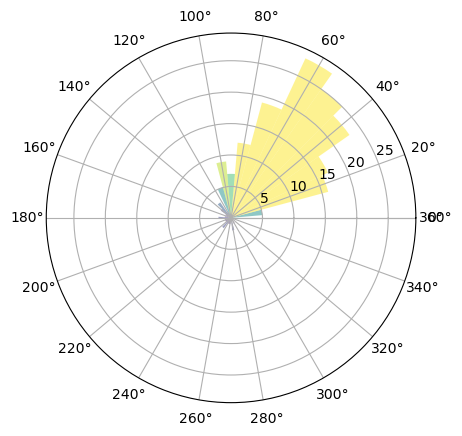

In [107]:
plotAngleHist(angles)

In [6]:
test_1d=glob.glob("../data/rendered/soma/1D/*.txt")
test_2d=glob.glob("../data/rendered/soma/2D/*.txt")
test_rand=glob.glob("../data/rendered/soma/Rand/*.txt")
a_1d=[]
a_2d=[]
a_un=[]
stats_2dr=[]
stats_randr=[]
thre=[50,280]
for i in range(len(test_1d)):
    vxs = readVXSfromLoc(test_1d[i])
    links = generateLinks(vxs, thre=thre, plot=0)
    angles = getAngle(vxs, links)
    a_1d.extend(angles)
for i in range(len(test_2d)):
    vxs = readVXSfromLoc(test_2d[i])
    links = generateLinks(vxs, thre=thre, plot=0)
    angles = getAngle(vxs, links)
    a_2d.extend(angles)
for i in range(len(test_rand)):
    vxs = readVXSfromLoc(test_rand[i])
    links = generateLinks(vxs, thre=thre, plot=0)
    angles = getAngle(vxs, links)
    a_un.extend(angles)

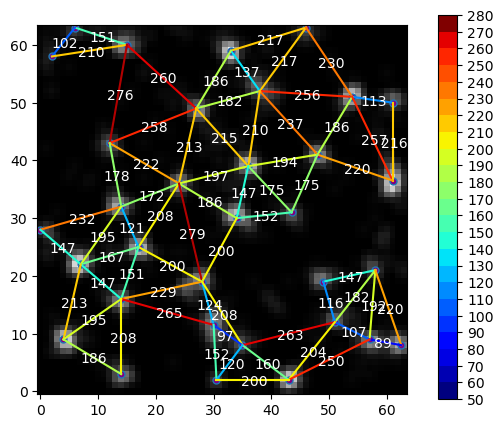

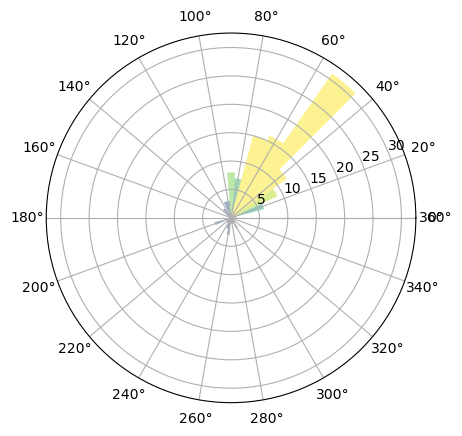

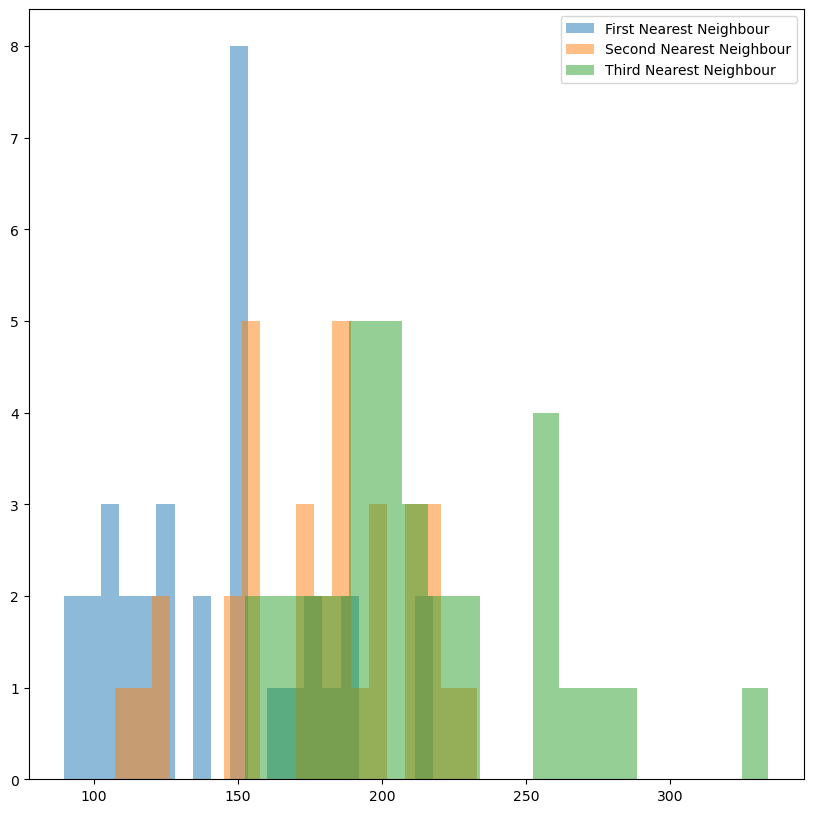

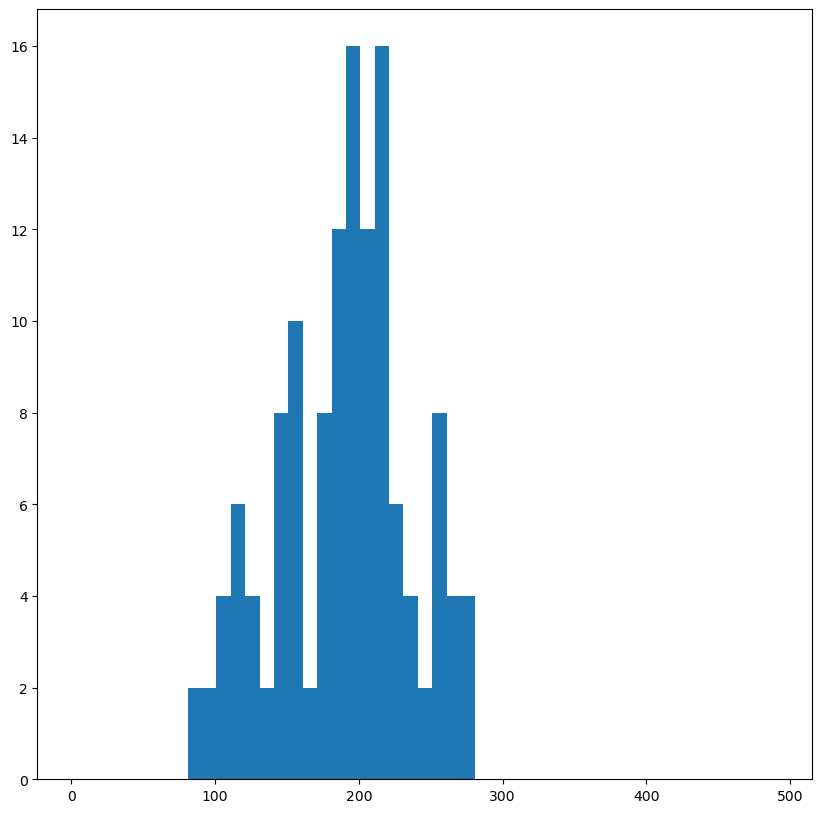

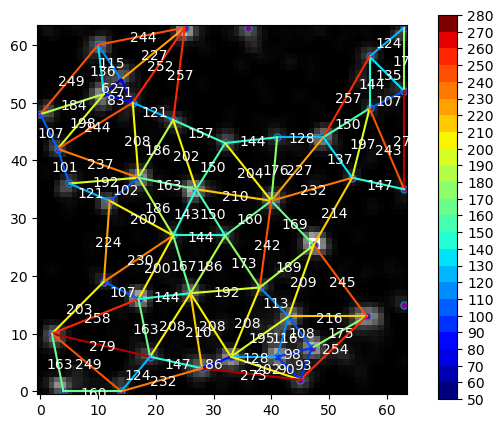

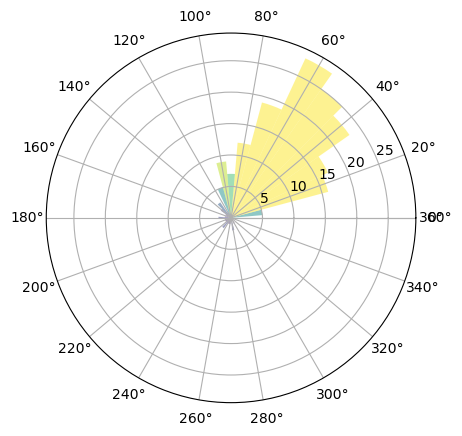

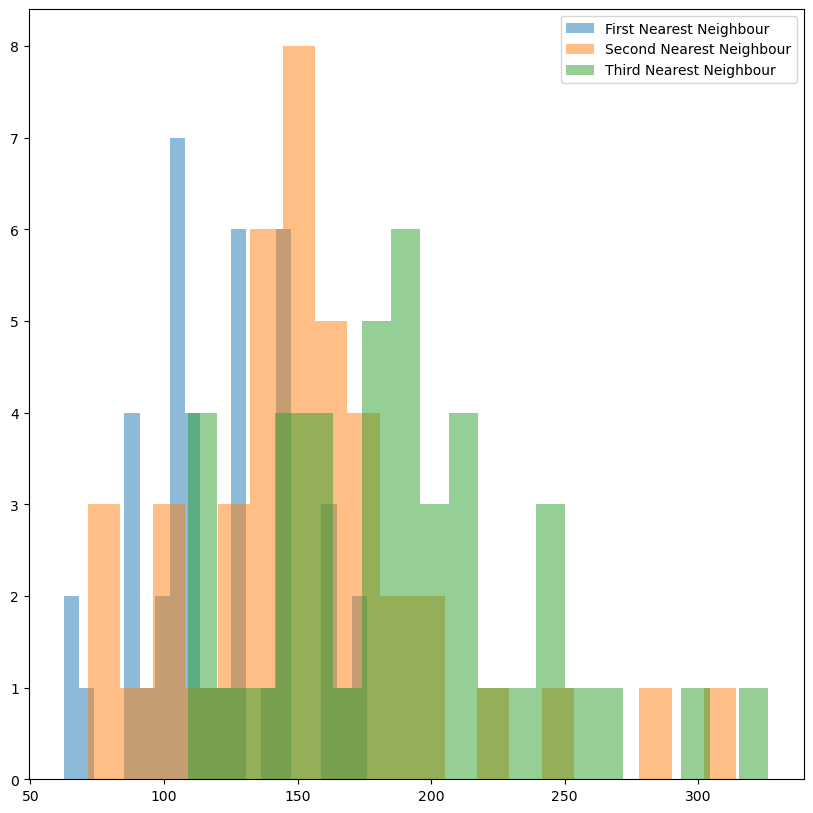

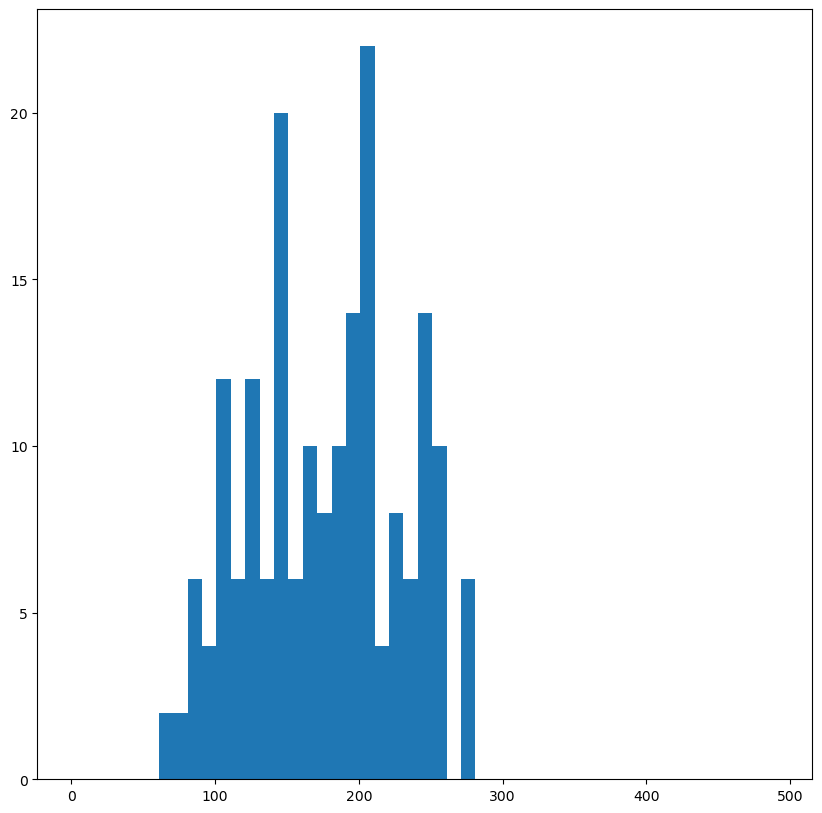

In [120]:
p_size = 16
thre=[50,280]
test_2d=glob.glob("../data/rendered/soma/2D/*.txt")
for i in range(2):
    plt.figure()
    vxs = readVXSfromLoc(test_2d[i],plot=1)
    links = generateLinks(vxs*p_size, thre=thre,plot=0)
    visualize(vxs, links, thre=thre, bins=10, p_size=p_size)
    plt.figure()
    angles=getAngle(vxs, links)
    plotAngleHist(angles)
    histKNN(vxs*16,plot=1)
    histLinks(vxs*16, links, bins=range(1,500,10))


    #stats_2dr.append(statsForVXS(vxs*16, plot=1, thre=thre))

In [ ]:
g = cv2.getGaussianKernel(3, sigma=1)
kernel = g*g.T
grid_size=64
test_1d=glob.glob("../data/rendered/soma/1D/*.txt")
test_2d=glob.glob("../data/rendered/soma/2D/*.txt")
test_rand=glob.glob("../data/rendered/soma/Rand/*.txt")
stats_1dr=[]
stats_2dr=[]
stats_randr=[]
stats_1ds=[]
stats_2ds=[]
stats_rands=[]
thre=[140,220]
for i in range(len(test_1d)):
    vxs = readVXSfromLoc(test_1d[i])
    stats_1dr.append(statsForVXS(vxs*16, plot=0, thre=thre))

for i in range(len(test_2d)):
    vxs = readVXSfromLoc(test_2d[i])
    stats_2dr.append(statsForVXS(vxs*16, plot=1, thre=thre))

for i in range(len(test_rand)):
    vxs = readVXSfromLoc(test_rand[i])
    stats_randr.append(statsForVXS(vxs*16, plot=0, thre=thre))

for i in range(len(test_rand)):    
    vxs = readVXSfromLoc(test_rand[i])
    counts = len(vxs)
    for j in range(10):
        vxs = np.random.rand(counts,2)*64*16
        stats_rands.append(statsForVXS(vxs, plot=0, thre=thre))

In [ ]:
#vxs_1D = sim1D()
#stats_1D = statsForVXS(vxs_1D, plot=0, thre=[140,220])

vxs_2D = sim2D(size=16*64,space=93)
stats_2D = statsForVXS(vxs_2D, plot=0, thre=[140,220])
for i in range(10):
    vxs=jitter(vxs_2D)
    stats_2ds.append(statsForVXS(vxs, plot=0, thre=thre))

In [ ]:
stats_1ds=[]
thre=[50,220]
vxs_1D = sim1D(size=64*16, spacex=60, spacey=187)
#stats_1D = statsForVXS(vxs_1D, plot=0, thre=[140,220])
for i in range(10):
    vxs=jitter(vxs_1D)
    stats_1ds.append(statsForVXS(vxs, plot=0, thre=thre))

In [ ]:
a=genPic(np.zeros([64,64]),vxs_1D,point=9)
plt.imshow(a)

In [ ]:
thre=[50,220]
# for i in range(len(test_2d)):
#     vxs = readVXSfromLoc(test_2d[i])
#     stats_2dr.append(statsForVXS(vxs*16, plot=1, thre=thre))

for i in range(len(test_1d)):
    plt.figure()
    vxs = readVXSfromLoc(test_1d[i], plot=1)
    #stats_1dr.append(statsForVXS(vxs*16, plot=1, thre=thre))

In [ ]:
stats_2dd=[]
for i in range(10):
    vxs = simRandD(box=64*16, d=100, n=56)
    stats_2dd.append(statsForVXS(vxs, plot=0, thre=thre))

In [ ]:
vxs = simRandD(box=64*16, d=100, n=56)
visualize(vxs,generateLinks(vxs,plot=0,thre=[50,200]))

In [ ]:
#sns.boxplot(np.array(stats_2dr)[:,4])
for i in range(5):
    plt.figure(figsize=[10,5])
    df = pd.Series(np.array(stats_1dr)[:,i], name="1D").to_frame().join(pd.Series(np.array(stats_2dr)[:,i], name="2D"))
    df = df.join(pd.Series(np.array(stats_randr)[:,i], name="Rand"))
    df = df.join(pd.Series(np.array(stats_1ds)[:,i], name="Simulated 1D"))
    df = df.join(pd.Series(np.array(stats_2ds)[:,i], name="Simulated 2D"))
    df = df.join(pd.Series(np.array(stats_rands)[:,i], name="Simulated Rand"))

    sns.boxplot(data=df, width = 0.2) 
    plt.title(labels[i]+" comparisons in real data")